In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import numpy as np
import torch.optim as optim
np.random.seed(0)
torch.manual_seed(0)

In [2]:
np.random.seed(0)
torch.manual_seed(0)
train = pd.read_csv("C:/Users/DELL G3/Desktop/neural network/project 1/mnist_train.csv",dtype = np.float32)

In [3]:
np.random.seed(0)
torch.manual_seed(0)

Y_numpy = train.label.values #take the label column
X_numpy = train.loc[:,train.columns != "label"].values #take all the columns except the lebel column

# train test split. Size of train data is 80% and size of validation data is 20%. 
x_train, x_validation , y_train, y_validation  = train_test_split(X_numpy, Y_numpy,test_size = 0.2, random_state = 42) 


# most important thing that our data to be in tensor type so our model can work
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train).type(torch.LongTensor) # data type is long
print(y_train.shape)
x_validation  = torch.Tensor(x_validation )
y_validation  = torch.Tensor(y_validation ).type(torch.LongTensor) # data type is long

# batch_size
batch_size = 128 #we used this after some trials 
#from that we can calculate that 1 epoch will need 375 iteration for the training 


#here we will creat data set of type tensor and assign each image to it label 
train = torch.utils.data.TensorDataset(x_train,y_train) 
validation = torch.utils.data.TensorDataset(x_validation ,y_validation )

# in data loader we split the data set into batches it will help us alot in the training phase 

train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
validation_loader = DataLoader(validation,batch_size = batch_size, shuffle = True)

torch.Size([48000])


In [4]:
np.random.seed(0)
torch.manual_seed(0)
#here we check if our device have a gpu or not and if it has we will use later to run the computaion on it which will take less time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
np.random.seed(0)
torch.manual_seed(0)
class mymodel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(mymodel, self).__init__()
        
        # Linear function 1: 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.relu2 = nn.ReLU()
        # Linear function 3: 150 --> 10
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.layernorm=nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(p=0.4) #the most comman is to use it on all the hidden layer but dont use it on convolution layers and dont use it on output layer and use it before the normalization layer also to make less compuation

    
    def forward(self, x):
        #1st hidden layer
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.layernorm(out)

        #after several tries we found that when we but the dropout in the 2nd hidden layer gives the highest accuracy
        #and also the best thing is to but normalization

        # 2nd hidden layer
        out=self.fc2(out)
        out=self.relu2(out)
        out=self.dropout(out)
        out=self.layernorm(out)
        
        #output layer
        out = self.fc3(out)
        
        return out


#creating our model
input_dim = 784  #this is the number of feature we have from each image 
hidden_dim = 150 #number of units in hidden layers
output_dim = 10  #number of unit in output layer and it will represnt the probability for each number

model = mymodel(input_dim, hidden_dim, output_dim).to(device)

In [6]:
np.random.seed(0)
torch.manual_seed(0)
error = nn.CrossEntropyLoss()
# Adam Optimizer
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [7]:
np.random.seed(0)
torch.manual_seed(0)
number_of_iterations = 0
num_epochs=10
loss_list = []
iteration_list = []
accuracy_list = []
val_loss_list = []
val_iteration_list = []
val_accuracy_list = []

In [8]:
#here we will call this function to calclute our loss and accuracy for training data 
def calc_train_accuracy_loss():
    model.train() #make sure that the model is on the training mode
    total = 0
    correct = 0
    for x, y in train_loader:
        x=x.to(device)
        y=y.to(device)
        outputs = model(x)
        predictions = torch.max(outputs, 1)[1].to(device)# here we will take the max between the 10 outputs given for a single image for example we put an image and the model return 10 numbers we will take the maximum and if that max number was in the first index then the model predict that the image is 0 
        correct += (predictions == y).sum()#here we calculate the number of correct predicts the output gives
        train_loss=error(outputs,y)
        total += len(y)
                
    train_accuracy = correct * 100 / total
    loss_list.append(train_loss.data)
    iteration_list.append(number_of_iterations)
    accuracy_list.append(train_accuracy)
    return train_accuracy,train_loss

In [9]:
def calc_validation_accuracy_loss():
    model.eval() #make sure that the model is on the evaluting mode
    total = 0
    correct = 0
    for x, y in validation_loader:
        x=x.to(device)
        y=y.to(device)
        outputs_v = model(x)#here we give the model the input and it will return the predict
        predictions = torch.max(outputs_v, 1)[1].to(device)# here we will take the max between the 10 outputs given for a single image for example we put an image and the model return 10 numbers we will take the maximum and if that max number was in the first index then the model predict that the image is 0 
        correct += (predictions == y).sum()#here we calculate the number of correct predicts the output gives
        val_loss=error(outputs_v,y)        
        total += len(y)
                
    validation_accuracy = correct * 100 / total
    val_loss_list.append(val_loss.data)
    val_iteration_list.append(number_of_iterations)
    val_accuracy_list.append(validation_accuracy)
    model.train()
    return validation_accuracy,val_loss

In [10]:
np.random.seed(0)
torch.manual_seed(0)

for epoch in range(num_epochs):
    correct_for_train=0
    for i, (input, labels) in enumerate(train_loader):
        model.train()#make sure that the model is on the training mode

        input=input.to(device)
        labels=labels.to(device)

        yhat=model(input)
        loss=error(yhat,labels)

        #backword
        optimizer.zero_grad() #make sure all the grad is zeroed so we dont update with previous grad
        #calculate the gradients
        loss.backward()
        
        #update weights
        optimizer.step()
        
        number_of_iterations += 1
        if number_of_iterations % 75 == 0:    #every 75 iteration we calcaulate the accuracy
            train_accuracy,train_loss= calc_train_accuracy_loss()
            model.eval()#but the model on evalution mode before calculating the validation accuracy
            with torch.no_grad():  #to turn off the gradient computation in this specific lines  it will make the computaion faster
                validation_accuracy,val_loss=calc_validation_accuracy_loss()
        
                
        if not (number_of_iterations % 250): #every 250 iteration we will print the loss and the accuracy
                print("Iteration: {}, Loss: {}, Accuracy on training: {}%".format(number_of_iterations, train_loss.data, train_accuracy))
                print("Iteration: {}, Loss: {}, Accuracy on validation: {}%".format(number_of_iterations, val_loss.data, validation_accuracy))
                print()

Iteration: 250, Loss: 0.1845422387123108, Accuracy on training: 93.59166717529297%
Iteration: 250, Loss: 0.1701371669769287, Accuracy on validation: 94.19166564941406%

Iteration: 500, Loss: 0.15380072593688965, Accuracy on training: 96.00833129882812%
Iteration: 500, Loss: 0.21044643223285675, Accuracy on validation: 95.84166717529297%

Iteration: 750, Loss: 0.11227774620056152, Accuracy on training: 97.03125%
Iteration: 750, Loss: 0.2505688965320587, Accuracy on validation: 96.7249984741211%

Iteration: 1000, Loss: 0.08706944435834885, Accuracy on training: 97.55833435058594%
Iteration: 1000, Loss: 0.2018759697675705, Accuracy on validation: 96.93333435058594%

Iteration: 1250, Loss: 0.024330224841833115, Accuracy on training: 98.11250305175781%
Iteration: 1250, Loss: 0.023013262078166008, Accuracy on validation: 97.20833587646484%

Iteration: 1500, Loss: 0.04791049286723137, Accuracy on training: 98.3687515258789%
Iteration: 1500, Loss: 0.11487574130296707, Accuracy on validation: 9

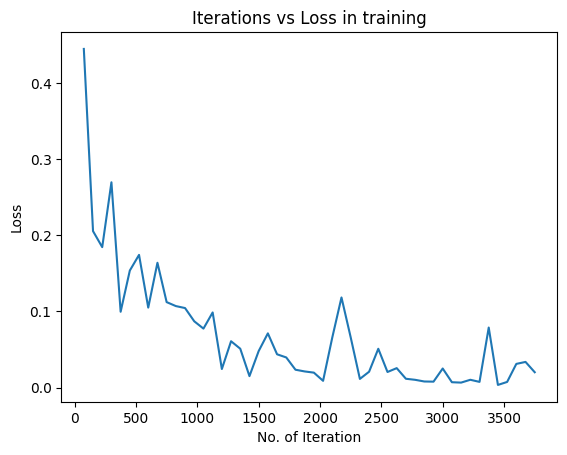

In [11]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss in training")
plt.show()

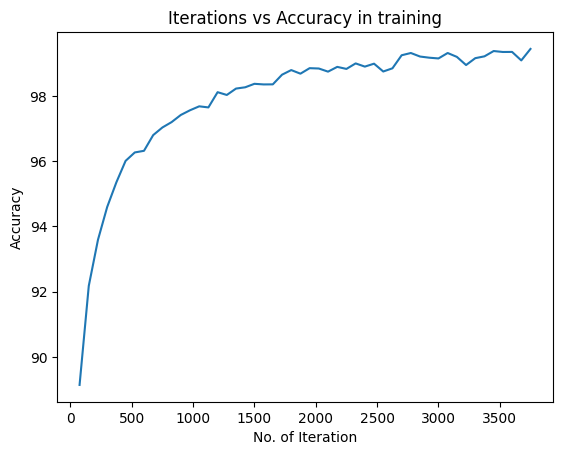

In [12]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy in training")
plt.show()

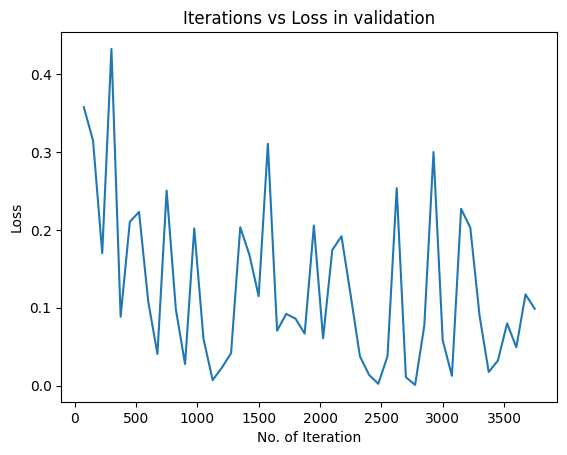

In [13]:
plt.plot(val_iteration_list, val_loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss in validation")
plt.show()

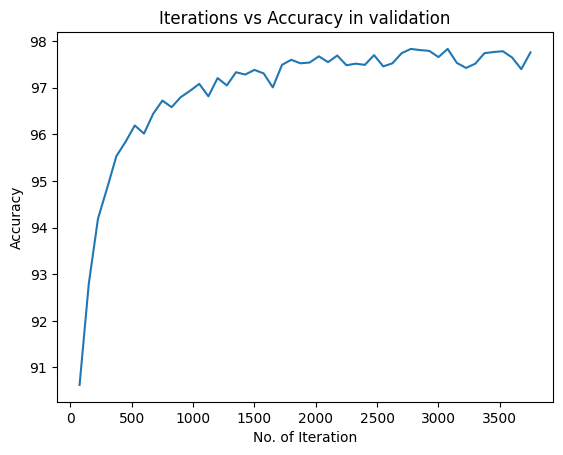

In [14]:
plt.plot(val_iteration_list, val_accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy in validation")
plt.show()